# Faster Polynomial Features

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%matplotlib inline

## Polynomial Features

The current implementation of [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) (0.20.2) implements a term by term product for each pair $X_i, X_j$ of features where $i \leqslant j$ which is not the most efficient way to do it.

In [3]:
import numpy.random
X = numpy.random.random((100, 5))

In [4]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
Xpoly = poly.fit_transform(X)
poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [5]:
%timeit poly.transform(X)

210 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The class [ExtendedFeatures](http://www.xavierdupre.fr/app/mlinsights/helpsphinx/mlinsights/mlmodel/extended_features.html) implements a different way to compute the polynomial features as it tries to reduce the number of calls to numpy by using broacasted vector multplications.

In [6]:
from mlinsights.mlmodel import ExtendedFeatures
ext = ExtendedFeatures(poly_degree=2)
Xpoly = ext.fit_transform(X)
ext.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x3^2',
 'x3 x4',
 'x4^2']

In [7]:
%timeit ext.transform(X)

38.5 µs ± 432 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Comparison with 5 features

In [8]:
from cpyquickhelper.numbers import measure_time

In [9]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r3 = measure_time("poly.fit_transform(X)", context=dict(X=X, poly=poly), repeat=5, number=10, div_by_number=True)
    r4 = measure_time("ext.fit_transform(X)", context=dict(X=X, ext=ext), repeat=5, number=10, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "poly+fit"
    r4["name"] = "ext+fit"
    r1["size"] = n
    r2["size"] = n
    r3["size"] = n
    r4["size"] = n
    res.append(r1)
    res.append(r2)
    res.append(r3)
    res.append(r4)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
63,0.028630,240,0.000248,0.028936,0.028318,ext+fit,10,5,100000
64,0.139464,240,0.000438,0.140284,0.138990,poly,10,5,200000
65,0.055398,240,0.000399,0.055847,0.054813,ext,10,5,200000
66,0.141629,240,0.002666,0.146769,0.139516,poly+fit,10,5,200000
67,0.057825,240,0.000914,0.059399,0.056846,ext+fit,10,5,200000


In [10]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,ext+fit,poly,poly+fit
size,,,,
1,0.000019,0.000114,0.000337,0.000215
2,0.000026,0.000118,0.000193,0.000232
5,0.000027,0.000117,0.000189,0.000232
10,0.000032,0.000115,0.000243,0.000248
20,0.000031,0.000113,0.000211,0.000249


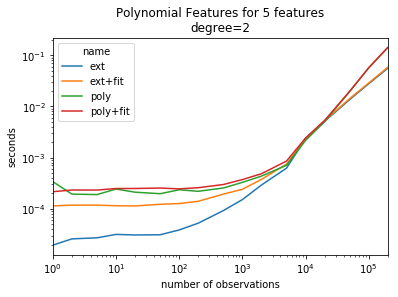

In [11]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of observations");

The gain is mostly visible for small dimensions.

## Comparison with 1000 observations

In this experiment, the number of observations is fixed to 1000 but the number of features varies.

In [12]:
poly = PolynomialFeatures(degree=2)
ext = ExtendedFeatures(poly_degree=2)
# implementation of PolynomialFeatures in 0.20.2
extslow = ExtendedFeatures(poly_degree=2, kind="poly-slow") 


res = []
for n in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 40, 50]:
    X = numpy.random.random((1000, n))
    poly.fit(X)
    ext.fit(X)
    extslow.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r3 = measure_time("extslow.transform(X)", context=dict(X=X, extslow=extslow), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r3["name"] = "extslow"
    r1["nfeat"] = n
    r2["nfeat"] = n
    r3["nfeat"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    x3 = extslow.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    r3["numf"] = x3.shape[1]
    res.append(r1)
    res.append(r2)
    res.append(r3)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,nfeat,number,numf,repeat
37,0.007274,240,0.000198,0.007628,0.007063,ext,40,30,861,5
38,0.018662,240,0.000158,0.018944,0.018472,extslow,40,30,861,5
39,0.024125,240,0.000230,0.024498,0.023862,poly,50,30,1326,5
40,0.011043,240,0.000080,0.011138,0.010898,ext,50,30,1326,5
41,0.029357,240,0.000075,0.029457,0.029225,extslow,50,30,1326,5


In [13]:
piv = df.pivot("nfeat", "name", "average")
piv[:5]

name,ext,extslow,poly
nfeat,,,
1,0.000026,0.000050,0.000207
2,0.000059,0.000084,0.000158
3,0.000081,0.000139,0.000174
4,0.000115,0.000207,0.000243
5,0.000146,0.000284,0.000353


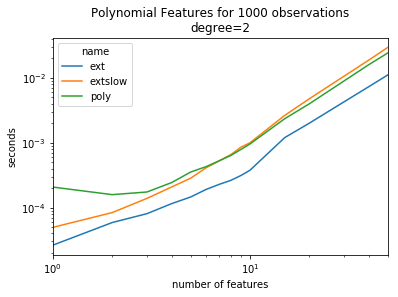

In [14]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\ndegree=2")
ax.set_ylabel("seconds")
ax.set_xlabel("number of features");

It is twice faster.

## Comparison for different degrees

In this experiment, the number of observations and features is fixed, the degree increases.

In [15]:
res = []
for n in [2, 3, 4, 5, 6, 7, 8]:
    X = numpy.random.random((1000, 4))
    poly = PolynomialFeatures(degree=n)
    ext = ExtendedFeatures(poly_degree=n)
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=5, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=5, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["degree"] = n
    r2["degree"] = n
    x1 = poly.transform(X)
    x2 = ext.transform(X)
    r1["numf"] = x1.shape[1]
    r2["numf"] = x2.shape[1]
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,degree,deviation,max_exec,min_exec,name,number,numf,repeat
9,0.001721,240,6,0.000048,0.001813,0.001675,ext,30,210,5
10,0.006690,240,7,0.000190,0.007066,0.006559,poly,30,330,5
11,0.002510,240,7,0.000008,0.002523,0.002503,ext,30,330,5
12,0.011836,240,8,0.001140,0.013301,0.010589,poly,30,495,5
13,0.004232,240,8,0.000464,0.004955,0.003853,ext,30,495,5


In [16]:
piv = df.pivot("degree", "name", "average")
piv[:5]

name,ext,poly
degree,,
2,0.000113,0.000348
3,0.000236,0.000557
4,0.000399,0.001077
5,0.000587,0.001947
6,0.001721,0.004333


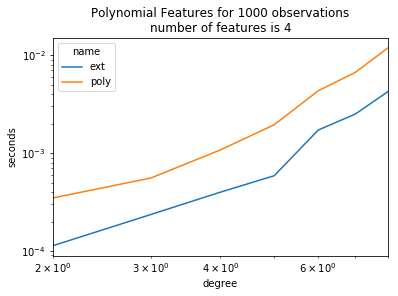

In [17]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 1000 observations\nnumber of features is 4")
ax.set_ylabel("seconds")
ax.set_xlabel("degree");

It is worth transposing.

## Same experiment with interaction_only=True

In [18]:
res = []
for n in [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 
          5000, 10000, 20000, 50000, 100000, 200000]:
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_interaction_only=True)
    X = numpy.random.random((n, 5))
    poly.fit(X)
    ext.fit(X)
    r1 = measure_time("poly.transform(X)", context=dict(X=X, poly=poly), repeat=2, number=30, div_by_number=True)
    r2 = measure_time("ext.transform(X)", context=dict(X=X, ext=ext), repeat=2, number=30, div_by_number=True)
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

,average,context_size,deviation,max_exec,min_exec,name,number,repeat,size
29,0.010243,240,0.000019,0.010262,0.010223,ext,30,2,50000
30,0.041786,240,0.000431,0.042217,0.041355,poly,30,2,100000
31,0.020699,240,0.000602,0.021300,0.020097,ext,30,2,100000
32,0.104215,240,0.001351,0.105566,0.102865,poly,30,2,200000
33,0.040607,240,0.000268,0.040875,0.040339,ext,30,2,200000


In [19]:
piv = df.pivot("size", "name", "average")
piv[:5]

name,ext,poly
size,,
1,0.000027,0.000296
2,0.000029,0.000223
5,0.000028,0.000197
10,0.000029,0.000170
20,0.000030,0.000169


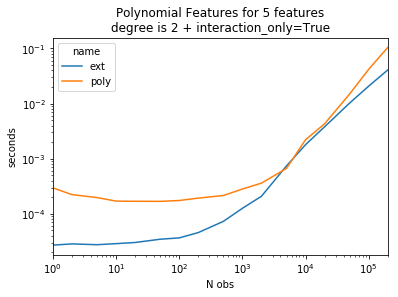

In [20]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 5 features\ndegree is 2 + interaction_only=True")
ax.set_ylabel("seconds")
ax.set_xlabel("N obs");

## Memory profiler

In [21]:
from memory_profiler import memory_usage
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(X)
memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)

[284.3046875]

In [22]:
res = []
for n in [10000, 50000, 100000, 200000]:
    X = numpy.random.random((n, 50))
    print(n)
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    ext = ExtendedFeatures(poly_degree=2, poly_interaction_only=True)
    poly.fit(X)
    ext.fit(X)
    r1 = memory_usage((poly.transform, (X,)), interval=0.1, max_usage=True)
    r2 = memory_usage((ext.transform, (X,)), interval=0.1, max_usage=True)
    r1 = {"memory": r1[0]}
    r2 = {"memory": r2[0]}
    r1["name"] = "poly"
    r2["name"] = "ext"
    r1["size"] = n
    r2["size"] = n
    res.append(r1)
    res.append(r2)
    
import pandas
df = pandas.DataFrame(res)
df.tail()

10000
50000
100000
200000


,memory,name,size
3,724.828125,ext,50000
4,1270.167969,poly,100000
5,1231.347656,ext,100000
6,2323.894531,poly,200000
7,2243.015625,ext,200000


In [23]:
piv = df.pivot("size", "name", "memory")
piv[:5]

name,ext,poly
size,,
10000,416.367188,420.183594
50000,724.828125,743.902344
100000,1231.347656,1270.167969
200000,2243.015625,2323.894531


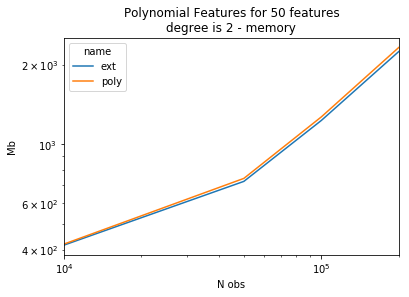

In [24]:
ax = piv.plot(logy=True, logx=True)
ax.set_title("Polynomial Features for 50 features\ndegree is 2 - memory")
ax.set_ylabel("Mb")
ax.set_xlabel("N obs");